# Installing Dependencies

In [ ]:
!pip install netCDF4
!pip install tqdm
!pip install matplotlib
!pip install basemap
!pip install cartopy
!pip install pytorch-msssim

  Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)


# Importing Libraries

In [ ]:
import os
import gzip
import tempfile
import numpy as np
import shutil
import urllib
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from datetime import datetime, timedelta

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import netCDF4
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = "/content/drive/My Drive/Graduate - Academic Work/Semester 3/EEE598 Deep Learning/Project/Data"
lat_long_file = root_dir + "/" + "lat_long.gz"

source_file = root_dir + "/Processed/25mm-new.zip"
destination_file = '/content/Data/25mm-new.zip'
os.makedirs('/content/Data', exist_ok=True)
shutil.copy(source_file, destination_file)
!unzip -q /content/Data/25mm-new.zip -d /content/Data

In [ ]:
#Load Lat long Information
with gzip.open(lat_long_file) as gz:
    grid_dataset = netCDF4.Dataset('dummy', mode='r', memory=gz.read())
    lat_grid_raw = grid_dataset['latitude'][:]
    lon_grid_raw = grid_dataset['longitude'][:]

# Defining region of interest
min_lat, max_lat = 23.65101718199114, 28.571809429628
min_lon, max_lon = 66.40570152424772, 71.273030867477
lat_grid_raw = np.array(lat_grid_raw)
lon_grid_raw = np.array(lon_grid_raw)

# Find the indices for the latitude and longitude bounds as in the previous code snippet
lat_indices = np.where((lat_grid_raw[:, 0] >= min_lat) & (lat_grid_raw[:, 0] <= max_lat))[0]
lon_indices = np.where((lon_grid_raw[0, :] >= min_lon) & (lon_grid_raw[0, :] <= max_lon))[0]

# Extract the latitude and longitude grid for plotting
lat_subset = lat_grid_raw[lat_indices.min():lat_indices.max()+1, 0]
lon_subset = lon_grid_raw[0, lon_indices.min():lon_indices.max()+1]

# Import Dataset As Individual Files



In [ ]:
class PrecipitationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the root directory containing the dataset.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = self._load_file_paths()

    def _load_file_paths(self):
        """
        Collect all .npy file paths under the root directory.
        """
        file_paths = []
        for year in os.listdir(self.root_dir):
            year_path = os.path.join(self.root_dir, year)
            if os.path.isdir(year_path):
                for file_name in os.listdir(year_path):
                    if file_name.endswith('.npy'):
                        file_paths.append(os.path.join(year_path, file_name))
        return file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Load the .npy file, apply optional transformations, and return as a PyTorch tensor.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        file_path = self.file_paths[idx]
        sample = np.load(file_path).astype(np.float32)

        if self.transform:
            sample = self.transform(sample)

        # Convert to PyTorch tensor
        sample = torch.tensor(sample)
        return sample


In [ ]:
dataset_dir = root_dir + '/Processed'
dataset = PrecipitationDataset(dataset_dir)

## Visualizing Sample From Dataset

In [ ]:
precipitation_data = dataset[0]


# Define coloring scheme for plot
turbo_cmap = plt.get_cmap('turbo')
print(len(range(1, turbo_cmap.N)))
colors = [(1, 1, 1)] + [turbo_cmap(i) for i in range(1, turbo_cmap.N)] # Adding (1,1,1) makes sure 0 intensity is white
custom_cmap_B = LinearSegmentedColormap.from_list("white_to_plasma", colors, N=256)
# Plotting with Cartopy for regional boundaries
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor("white")  # Set background to white
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.3)  # For finer boundaries, if desired
# Plot the rainfall data
rain_plot = ax.pcolormesh(lon_subset, lat_subset, precipitation_data, shading='auto', cmap=custom_cmap_B, transform=ccrs.PlateCarree(), vmin=0, vmax=70)
plt.colorbar(rain_plot, ax=ax, orientation='vertical', label='Rainfall (mm)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

IndexError: list index out of range

# Import Dataset As Sequences

In [ ]:
class ConvLSTMDataset(Dataset):
    def __init__(self, root_dir, sequence_length=8, transform=None, preload=True, min_val=0.0, max_val=100.0):
        """
        Args:
            root_dir (str): Path to the root directory containing the dataset.
            sequence_length (int): Number of frames in each sequence.
            transform (callable, optional): Optional transform to be applied on a sample.
            preload (bool): Whether to preload all data into memory.
            min_val (float): Minimum precipitation intensity for normalization.
            max_val (float): Maximum precipitation intensity for normalization.
        """
        self.root_dir = root_dir
        self.sequence_length = sequence_length
        self.transform = transform
        self.preload = preload
        self.min_val = min_val
        self.max_val = max_val
        self.sequences = self._create_sequences()

        if self.preload:
            self.data = self._preload_data()

    def _load_file_paths(self):
        """
        Collect all .npy file paths under the root directory, sorted temporally.
        """
        file_paths = []
        for year in sorted(os.listdir(self.root_dir)):  # Sort years for temporal order
            year_path = os.path.join(self.root_dir, year)
            if os.path.isdir(year_path):
                files = sorted(os.listdir(year_path))  # Sort files within each year
                file_paths.extend(os.path.join(year_path, f) for f in files if f.endswith('.npy'))
        return file_paths

    def _create_sequences(self):
          """
          Create sequences of file paths with the specified sequence length,
          including only those where at least one frame has intensity > 25mm.
          """
          file_paths = self._load_file_paths()
          valid_sequences = []

          # Iterate to create sequences
          for i in range(0, len(file_paths)//self.sequence_length + 1):
              sequence_files = file_paths[i:i + self.sequence_length]

              # Check if the sequence meets the intensity condition
              include_sequence = False
              for file in sequence_files:
                  frame = np.load(file).astype(np.float32)  # Load the frame
                  if np.any(frame > 20.0):  # Check if any value exceeds 25mm
                      include_sequence = True
                      break

              if include_sequence:
                  valid_sequences.append(sequence_files)

          return valid_sequences

    def _normalize(self, frame):
        """
        Normalize a single frame using min-max normalization.
        """
        return (frame - self.min_val) / (self.max_val - self.min_val)

    def _preload_data(self):
        """
        Preload all sequences into memory.
        """
        preloaded_data = []
        for sequence_files in self.sequences:
            sequence = np.array([np.load(file).astype(np.float32) for file in sequence_files])
            sequence = np.array([self._normalize(frame) for frame in sequence])
            if self.transform:
                sequence = np.array([self.transform(frame) for frame in sequence])
            sequence = torch.tensor(sequence).unsqueeze(1)  # Add channel dimension
            preloaded_data.append(sequence)
        return preloaded_data

    def __len__(self):
        """
        Return the number of sequences.
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Get a preloaded sequence or load it dynamically if preloading is disabled.
        """
        if self.preload:
            return self.data[idx]
        else:
            sequence_files = self.sequences[idx]
            sequence = np.array([np.load(file).astype(np.float32) for file in sequence_files])
            sequence = np.array([self._normalize(frame) for frame in sequence])
            if self.transform:
                sequence = np.array([self.transform(frame) for frame in sequence])
            sequence = torch.tensor(sequence).unsqueeze(1)  # Add channel dimension
            return sequence


In [ ]:
dataset_dir = "/content/Data/25mm/"
sequence_length = 16
dataset = ConvLSTMDataset(dataset_dir, sequence_length, preload=False)
print(len(dataset))
sequence = dataset[0]
print(sequence.shape)


1473
torch.Size([16, 1, 153, 135])


## Visualizing Sequence

torch.Size([153, 135])
tensor(0.2493)


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


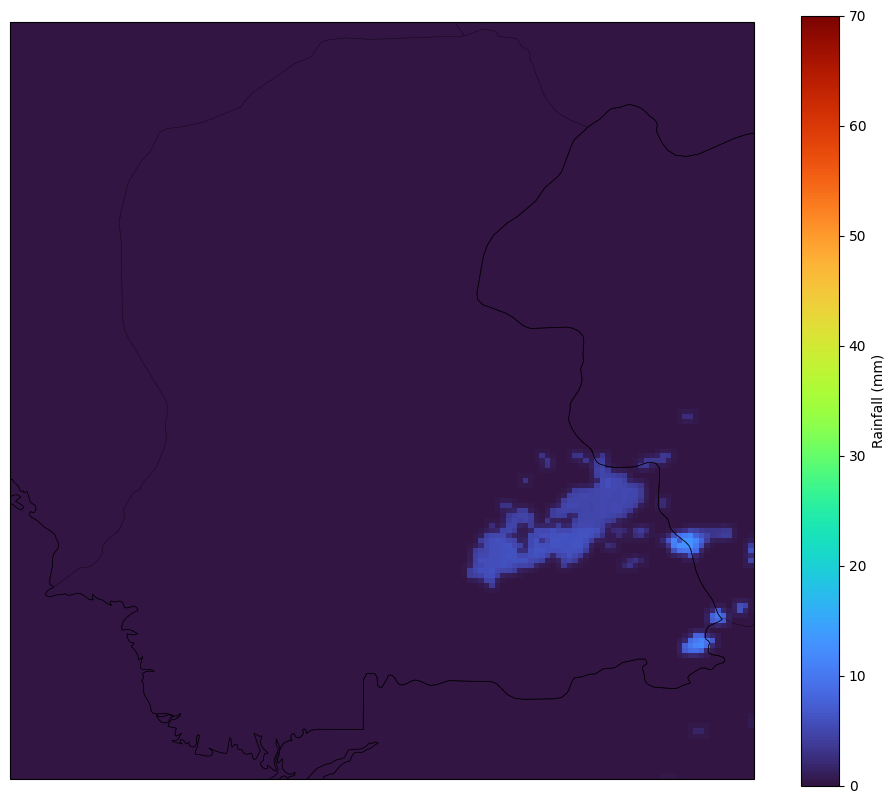

In [ ]:
sequence = dataset[500]
precipitation_sequence = sequence.squeeze(1)  # Remove the channel dimension
print(precipitation_sequence[0].shape)
print(precipitation_sequence[0].max())

# Define coloring scheme for plot
turbo_cmap = plt.get_cmap('turbo')
colors = [turbo_cmap(i) for i in range(1, turbo_cmap.N)]  # Adding white for 0 intensity
custom_cmap_B = LinearSegmentedColormap.from_list("white_to_turbo", colors, N=256)

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_facecolor("white")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.3)  # For finer boundaries

# Initialize the plot with the first frame
rain_plot = ax.pcolormesh(lon_subset, lat_subset, precipitation_sequence[1]*100, shading='auto', cmap=custom_cmap_B,
                          transform=ccrs.PlateCarree(), vmin=0, vmax=70)
cbar = plt.colorbar(rain_plot, ax=ax, orientation='vertical', label='Rainfall (mm)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Animation update function
def update(frame):
    rain_plot.set_array(precipitation_sequence[frame].ravel()*100)  # Update the data
    return rain_plot,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(sequence), interval=500, blit=True)

# To save as a GIF
ani.save('rainfall_animation.gif', writer='imagemagick', fps=2)

# Organizing Data For Training, Validation, and Testing

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split, Subset

train_ratio = 0.75  # Percentage of data for training
val_ratio = 0.15   # Percentage of data for validation
test_ratio = 0.1   # Percentage of data for testing
batch_size = 16

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size
print(total_size, train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

1473 1104 220 149


#Creating LSTM Model

## Defining the Model Class

In [ ]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        mean = x.mean(dim=(2, 3), keepdim=True)
        var = x.var(dim=(2, 3), keepdim=True, unbiased=False)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight * x + self.bias


class ConvLSTMBlock(nn.Module):
    def __init__(self, in_channels, num_features, kernel_size=3, padding=1, stride=1):
        super().__init__()
        self.num_features = num_features
        self.conv = self._make_layer(in_channels+num_features, num_features*4,
                                       kernel_size, padding, stride)

    def _make_layer(self, in_channels, out_channels, kernel_size, padding, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, padding=padding, stride=stride, bias=False),
            LayerNorm2d(out_channels))

    def forward(self, inputs):
        '''

        :param inputs: (B, S, C, H, W)
        :param hidden_state: (hx: (B, S, C, H, W), cx: (B, S, C, H, W))
        :return:
        '''
        outputs = []
        B, S, C, H, W = inputs.shape
        hx = torch.zeros(B, self.num_features, H, W).to(inputs.device)
        cx = torch.zeros(B, self.num_features, H, W).to(inputs.device)
        for t in range(S):
            combined = torch.cat([inputs[:, t], # (B, C, H, W)
                                  hx], dim=1)
            gates = self.conv(combined)
            ingate, forgetgate, cellgate, outgate = torch.split(gates, self.num_features, dim=1)
            ingate = torch.sigmoid(ingate)
            forgetgate = torch.sigmoid(forgetgate)
            outgate = torch.sigmoid(outgate)

            cy = (forgetgate * cx) + (ingate * cellgate)
            hy = outgate * torch.tanh(cy)
            outputs.append(hy)
            hx = hy
            cx = cy

        return torch.stack(outputs).permute(1, 0, 2, 3, 4).contiguous() # (S, B, C, H, W) -> (B, S, C, H, W)

class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = []
        for idx, params in enumerate(config.encoder):
            setattr(self, params[0]+'_'+str(idx), self._make_layer(*params))
            self.layers.append(params[0]+'_'+str(idx))

    def _make_layer(self, type, activation, in_ch, out_ch, kernel_size, padding, stride):
        layers = []
        if type == 'conv':
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
            layers.append(LayerNorm2d(out_ch))
            if activation == 'leaky': layers.append(nn.LeakyReLU(inplace=True))
            elif activation == 'relu': layers.append(nn.ReLU(inplace=True))
        elif type == 'convlstm':
            layers.append(ConvLSTMBlock(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride))
        return nn.Sequential(*layers)

    def forward(self, x):
        '''
        :param x: (B, S, C, H, W)
        :return:
        '''
        outputs = [x]
        for layer in self.layers:
            if 'conv_' in layer:
                B, S, C, H, W = x.shape
                x = x.view(B*S, C, H, W)
            x = getattr(self, layer)(x)
            if 'conv_' in layer:
              x = x.view(B, S, x.shape[1], x.shape[2], x.shape[3])
            if 'convlstm' in layer:
              outputs.append(x)
        return outputs

class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = []
        for idx, params in enumerate(config.decoder):
            setattr(self, params[0]+'_'+str(idx), self._make_layer(*params))
            self.layers.append(params[0]+'_'+str(idx))

    def _make_layer(self, type, activation, in_ch, out_ch, kernel_size, padding, stride):
        layers = []
        if type == 'conv':
            layers.append(nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
            layers.append(LayerNorm2d(out_ch))
            if activation == 'leaky': layers.append(nn.LeakyReLU(inplace=True))
            elif activation == 'relu': layers.append(nn.ReLU(inplace=True))
            elif activation == 'sigmoid': layers.append(nn.Sigmoid())
        elif type == 'convlstm':
            layers.append(ConvLSTMBlock(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride))
        elif type == 'deconv':
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding, stride=stride, bias=False))
            layers.append(LayerNorm2d(out_ch))
            if activation == 'leaky': layers.append(nn.LeakyReLU(inplace=True))
            elif activation == 'relu': layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, encoder_outputs):
        '''
        :param x: (B, S, C, H, W)
        :return:
        '''
        idx = len(encoder_outputs)-1
        for layer in self.layers:
            if 'conv_' in layer or 'deconv_' in layer:
                x = encoder_outputs[idx]
                B, S, C, H, W = x.shape
                x = x.view(B*S, C, H, W)
                x = getattr(self, layer)(x)
                x = x.view(B, S, x.shape[1], x.shape[2], x.shape[3])
            elif 'convlstm' in layer:
                idx -= 1
                if x.shape[3:] != encoder_outputs[idx].shape[3:]:
                    min_h = min(x.shape[3], encoder_outputs[idx].shape[3])
                    min_w = min(x.shape[4], encoder_outputs[idx].shape[4])
                    x = x[:, :, :, :min_h, :min_w]
                    encoder_outputs[idx] = encoder_outputs[idx][:, :, :, :min_h, :min_w]
                x = torch.cat([encoder_outputs[idx], x], dim=2)
                x = getattr(self, layer)(x)
                encoder_outputs[idx] = x
        return x

class ConvLSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



## Defining Model Configuration


In [ ]:
class ModelConfig:
    # (type, activation, in_ch, out_ch, kernel_size, padding, stride)
    encoder = [('conv', 'leaky',    1, 32, 3, 1, 2),
             ('convlstm', '',      32, 32, 3, 1, 1),
             ('conv', 'leaky',     32, 64, 3, 1, 2),
             ('convlstm', '',      64, 64, 3, 1, 1),
             ('conv', 'leaky',     64, 128, 3, 1, 2),
             ('convlstm', '',     128, 128, 3, 1, 1)]
    decoder = [('deconv', 'leaky',128, 64, 4, 1, 2),
               ('convlstm', '',   128, 64, 3, 1, 1),
               ('deconv', 'leaky', 64, 32, 4, 1, 2),
               ('convlstm', '',    64, 32, 3, 1, 1),
               ('deconv', 'leaky', 32, 32, 4, 1, 2),
               ('convlstm', '',    33, 32, 3, 1, 1),
               ('conv', 'sigmoid', 32, 1, 1, 0, 1)]

config = ModelConfig()

model = ConvLSTM(config)


# Training the Model


In [ ]:
from pytorch_msssim import ssim

def weighted_mse_loss(predictions, targets):
    """
    Computes the weighted Mean Squared Error (B-MSE) loss.

    Parameters:
        predictions (torch.Tensor): Predicted precipitation intensities (normalized).
        targets (torch.Tensor): Ground truth precipitation intensities (normalized).

    Returns:
        torch.Tensor: Weighted MSE loss.
    """
    # Reverse normalization (assuming values were normalized by dividing by 100)
    predictions = predictions * 100
    targets = targets * 100

    # Compute weights based on the intensity values
    with torch.no_grad():
        weights = torch.ones_like(targets)
        weights[targets < 2] = 1
        weights[(targets >= 2) & (targets < 5)] = 2
        weights[(targets >= 5) & (targets < 10)] = 5
        weights[(targets >= 10) & (targets < 30)] = 10
        weights[targets >= 30] = 30

    # Compute the weighted MSE
    loss = torch.mean(weights * (predictions - targets) ** 2)
    return loss



# Combine SSIM with pixel-wise loss
def combined_loss(pred, target):
    ssim_loss = 1 - ssim(pred, target, data_range=1.0, size_average=True)
    mse = nn.MSELoss()
    mse_loss = mse(pred, target)
    loss = ((ssim_loss*0.60) + (mse_loss*0.4)/2)
    return loss

def train(model, train_loader, criterion, optimizer, device='cpu'):
    model.train()
    epoch_records = {'loss': []}
    num_batchs = len(train_loader)
    for batch_idx, batch_data in enumerate(train_loader):
        inputs = batch_data[:, :-8].float().to(device)
        targets = batch_data[:, 8:].float().to(device)
        outputs = model(inputs)
        losses = combined_loss(outputs, targets)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_records['loss'].append(losses.item())

    return epoch_records

def valid(model, valid_loader, criterion, device='cpu'):
    model.eval()
    epoch_records = {'loss': []}
    num_batchs = len(valid_loader)
    for batch_idx, batch_data in enumerate(valid_loader):
        with torch.no_grad():
            inputs = batch_data[:, :-8].float().to(device)
            targets = batch_data[:, 8:].float().to(device)
            outputs = model(inputs)
            losses = combined_loss(outputs, targets)
            epoch_records['loss'].append(losses.item())

    return epoch_records

def test(model, test_loader, criterion, device='cpu'):
    model.eval()
    epoch_records = {'loss': []}
    num_batchs = len(test_loader)
    for batch_idx, batch_data in enumerate(test_loader):
        with torch.no_grad():
            inputs = batch_data[:, :-8].float().to(device)
            targets = batch_data[:, 8:].float().to(device)
            outputs = model(inputs)
            losses = criterion(outputs, targets)
            epoch_records['loss'].append(losses.item())

    return epoch_records


def test_combined(model, test_loader, criterion, device='cpu'):
    model.eval()
    epoch_records = {'loss': []}
    num_batchs = len(test_loader)
    for batch_idx, batch_data in enumerate(test_loader):
        with torch.no_grad():
            inputs = batch_data[:, :-8].float().to(device)
            targets = batch_data[:, 8:].float().to(device)
            outputs = model(inputs)
            losses = combined_loss(outputs, targets)
            epoch_records['loss'].append(losses.item())

    return epoch_records

def test_weight_mse(model, test_loader, criterion, device='cpu'):
    model.eval()
    epoch_records = {'loss': []}
    num_batchs = len(test_loader)
    for batch_idx, batch_data in enumerate(test_loader):
        with torch.no_grad():
            inputs = batch_data[:, :-8].float().to(device)
            targets = batch_data[:, 8:].float().to(device)
            outputs = model(inputs)
            losses = weighted_mse_loss(outputs, targets)
            epoch_records['loss'].append(losses.item())

    return epoch_records

In [ ]:
import ipywidgets as widgets
from IPython.display import display


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTM(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 200

train_losses = []
validation_losses = []

# Early stopping parameters
patience = 10
min_delta = 0.01
best_val_loss = float('inf')
epochs_no_improve = 0

# Global flag for stopping training
stop_training = False

# Create a stop button
button = widgets.Button(description="Stop Training")
output = widgets.Output()

# Function to stop training when button is clicked
def stop_training_callback(change):
    global stop_training
    stop_training = True
    with output:
        print("Training will stop after this epoch.")

# Link button to the callback
button.on_click(stop_training_callback)
display(button, output)

# Training Loop
for epoch in range(num_epochs):
    if stop_training:
        print("Stopping training at epoch:", epoch)
        break

    train_records = train(model, train_loader, criterion, optimizer, device)
    valid_records = valid(model, val_loader, criterion, device)

    train_losses.append(np.mean(train_records['loss']))
    validation_losses.append(np.mean(valid_records['loss']))

    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}")


print("Training completed.")


Button(description='Stop Training', style=ButtonStyle())

Output()

Epoch 1, Train Loss: 0.6415, Val Loss: 0.6384
Epoch 2, Train Loss: 0.6364, Val Loss: 0.6343
Epoch 3, Train Loss: 0.6327, Val Loss: 0.6310
Epoch 4, Train Loss: 0.6295, Val Loss: 0.6279
Epoch 5, Train Loss: 0.6265, Val Loss: 0.6254
Epoch 6, Train Loss: 0.6239, Val Loss: 0.6224
Epoch 7, Train Loss: 0.6162, Val Loss: 0.6078
Epoch 8, Train Loss: 0.6004, Val Loss: 0.5938
Epoch 9, Train Loss: 0.5885, Val Loss: 0.5831
Epoch 10, Train Loss: 0.5779, Val Loss: 0.5726
Epoch 11, Train Loss: 0.5675, Val Loss: 0.5621
Epoch 12, Train Loss: 0.5565, Val Loss: 0.5512
Epoch 13, Train Loss: 0.5459, Val Loss: 0.5404
Epoch 14, Train Loss: 0.5350, Val Loss: 0.5294
Epoch 15, Train Loss: 0.5238, Val Loss: 0.5183
Epoch 16, Train Loss: 0.5129, Val Loss: 0.5074
Epoch 17, Train Loss: 0.5018, Val Loss: 0.4962
Epoch 18, Train Loss: 0.4908, Val Loss: 0.4854
Epoch 19, Train Loss: 0.4798, Val Loss: 0.4742
Epoch 20, Train Loss: 0.4688, Val Loss: 0.4634
Epoch 21, Train Loss: 0.4577, Val Loss: 0.4520
Epoch 22, Train Loss: 

KeyboardInterrupt: 

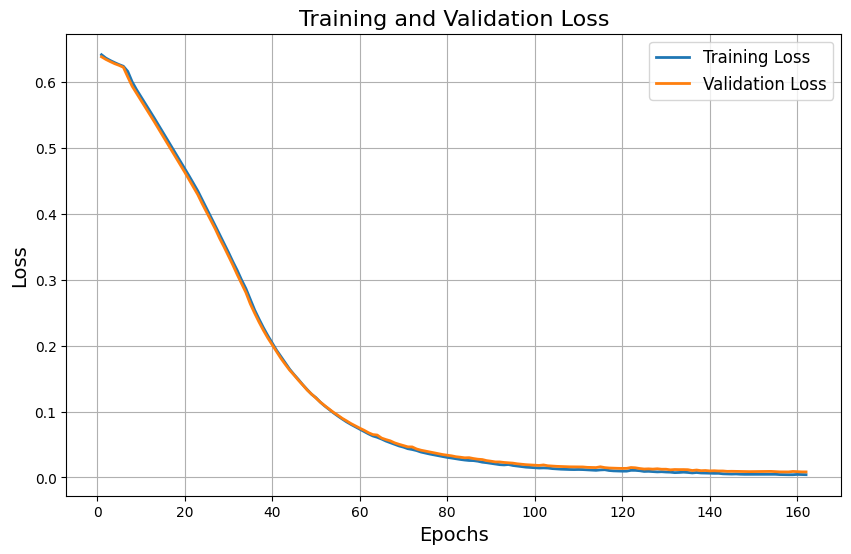

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
from datetime import datetime

# Ensure you have data in train_losses and validation_losses
if not train_losses or not validation_losses:
    print("No data to plot. Ensure training and validation losses are being recorded.")
else:
    # Generate timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = f"training_validation_loss_{timestamp}.png"

    # Plot the training and validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', linewidth=2)
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', linewidth=2)

    # Add labels, title, and legend
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.legend(fontsize=12)

    # Add grid for better visualization
    plt.grid(True)

    # Save the plot with timestamp in the filename
    plt.savefig(plot_filename, dpi=300)  # Save with high resolution
    plt.show()

    # Provide a download link in Google Colab
    files.download(plot_filename)


In [ ]:
import gc
# Clear all PyTorch GPU memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch
import os
from IPython.display import FileLink

# Save the model after training
model_save_path = "trained_model.pth"

# Save the state dictionary (preferred method)
torch.save(model.state_dict(), model_save_path)

# Generate a downloadable link if in Jupyter
if os.path.exists(model_save_path):
    print(f"Model saved at {model_save_path}.")
    display(FileLink(model_save_path))
else:
    print("Error: Model file not found.")

# Save the entire model
torch.save(model, "complete_model.pth")
print("Model saved successfully as 'complete_model.pth'.")


Model saved at trained_model.pth.


/content/trained_model.pth

Model saved successfully as 'complete_model.pth'.


In [ ]:
criterion = nn.MSELoss()
test_records = test_weight_mse(model, test_loader, criterion, device)

test_loss = np.sqrt(np.mean(test_records['loss']))
print(f"Test Loss: {test_loss:4f}")


test_records = test_combined(model, test_loader, criterion, device)

test_loss = np.mean(test_records['loss'])
print(f"Test Loss: {test_loss:4f}")

Test Loss: 5.783215
Test Loss: 0.008872


# Testing Model With Random Sample


In [ ]:
# Performing Inference
model.eval()
batch_num = 2
print(len(test_loader))
for batch_idx, batch_data in enumerate(val_loader):
  print(batch_idx)
  with torch.no_grad():
    if batch_num == batch_idx:
        inputs = batch_data[:, :-16].float().to(device)
        targets = batch_data[:, 16:].float().to(device)
        outputs = model(inputs)
        losses = combined_loss(outputs, targets)
        print(losses.item())
        break


3
0
1
2
0.005481131374835968


In [ ]:
input_16 = torch.unbind(inputs.cpu().detach(), dim=0)  # 16 tensors of size (8, 1, 153, 135)
final_inputs = []
for sample in input_16:
    sub_samples = torch.unbind(sample, dim=0)  # 8 tensors of size (1, 153, 135)
    sub_samples = [(sub_sample.squeeze(dim=0)*100) for sub_sample in sub_samples]  # 8 tensors of size (153, 135)
    final_inputs.append(sub_samples)

target_16 = torch.unbind(targets.cpu().detach(), dim=0)  # 16 tensors of size (8, 1, 153, 135)
final_targets = []
for sample in target_16:
    sub_samples = torch.unbind(sample, dim=0)  # 8 tensors of size (1, 153, 135)
    sub_samples = [(sub_sample.squeeze(dim=0)*100) for sub_sample in sub_samples]  # 8 tensors of size (153, 135)
    final_targets.append(sub_samples)


prediction_16 = torch.unbind(outputs.cpu().detach(), dim=0)  # 16 tensors of size (8, 1, 153, 135)
final_prediction = []
for sample in prediction_16:
    sub_samples = torch.unbind(sample, dim=0)  # 8 tensors of size (1, 153, 135)
    sub_samples = [(sub_sample.squeeze(dim=0)*100) for sub_sample in sub_samples]  # 8 tensors of size (153, 135)
    final_prediction.append(sub_samples)

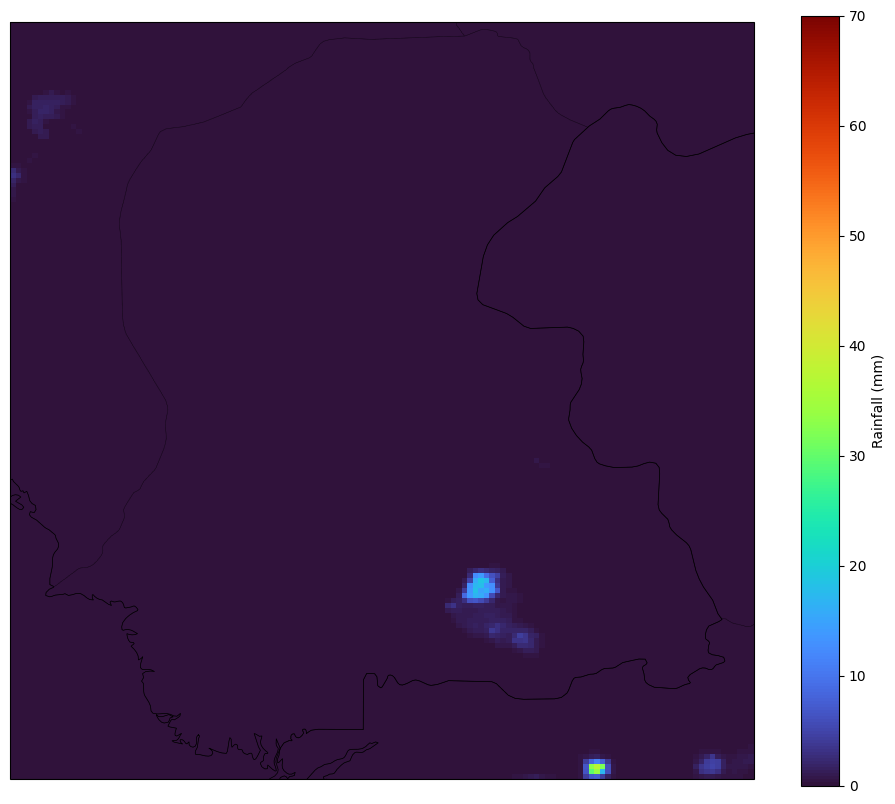

In [ ]:
precipitation_sequence = final_inputs[8]

# Define coloring scheme for plot
turbo_cmap = plt.get_cmap('turbo')
colors = [turbo_cmap(i) for i in range(0, turbo_cmap.N)]  # Adding white for 0 intensity
custom_cmap_B = LinearSegmentedColormap.from_list("white_to_turbo", colors, N=256)

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_facecolor("white")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.3)  # For finer boundaries

# Initialize the plot with the first frame
rain_plot = ax.pcolormesh(lon_subset, lat_subset, precipitation_sequence[0].cpu(), shading='auto', cmap=custom_cmap_B,
                          transform=ccrs.PlateCarree(), vmin=0, vmax=70)
cbar = plt.colorbar(rain_plot, ax=ax, orientation='vertical', label='Rainfall (mm)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Animation update function
def update(frame):
    rain_plot.set_array(precipitation_sequence[frame].cpu().detach().numpy().ravel())  # Update the data
    return rain_plot,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(precipitation_sequence), interval=500, blit=True)

# To save as a GIF
ani.save('input.gif', writer='imagemagick', fps=1)

16


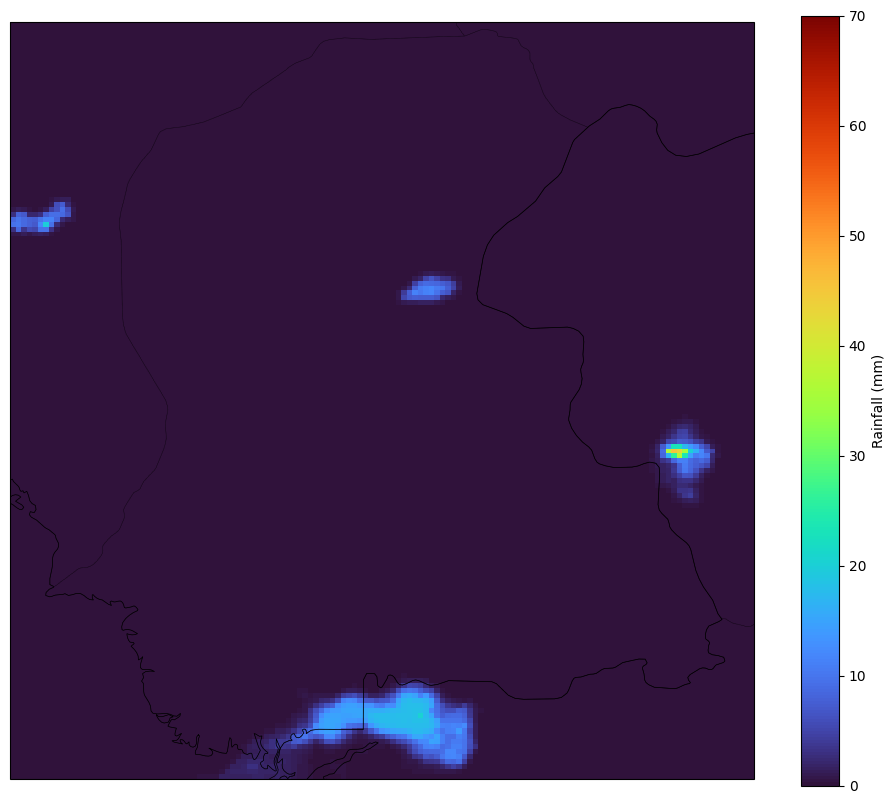

In [ ]:
precipitation_sequence = final_targets[8]

# Define coloring scheme for plot
turbo_cmap = plt.get_cmap('turbo')
colors = [turbo_cmap(i) for i in range(0, turbo_cmap.N)]  # Adding white for 0 intensity
custom_cmap_B = LinearSegmentedColormap.from_list("white_to_turbo", colors, N=256)

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_facecolor("white")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.3)  # For finer boundaries

# Initialize the plot with the first frame
rain_plot = ax.pcolormesh(lon_subset, lat_subset, precipitation_sequence[0].cpu(), shading='auto', cmap=custom_cmap_B,
                          transform=ccrs.PlateCarree(), vmin=0, vmax=70)
cbar = plt.colorbar(rain_plot, ax=ax, orientation='vertical', label='Rainfall (mm)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Animation update function
def update(frame):
    rain_plot.set_array(precipitation_sequence[frame].cpu().detach().numpy().ravel())  # Update the data
    return rain_plot,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(precipitation_sequence), interval=500, blit=True)

# To save as a GIF
print(len(precipitation_sequence))
ani.save('target.gif', writer='imagemagick', fps=1)

tensor(100.)


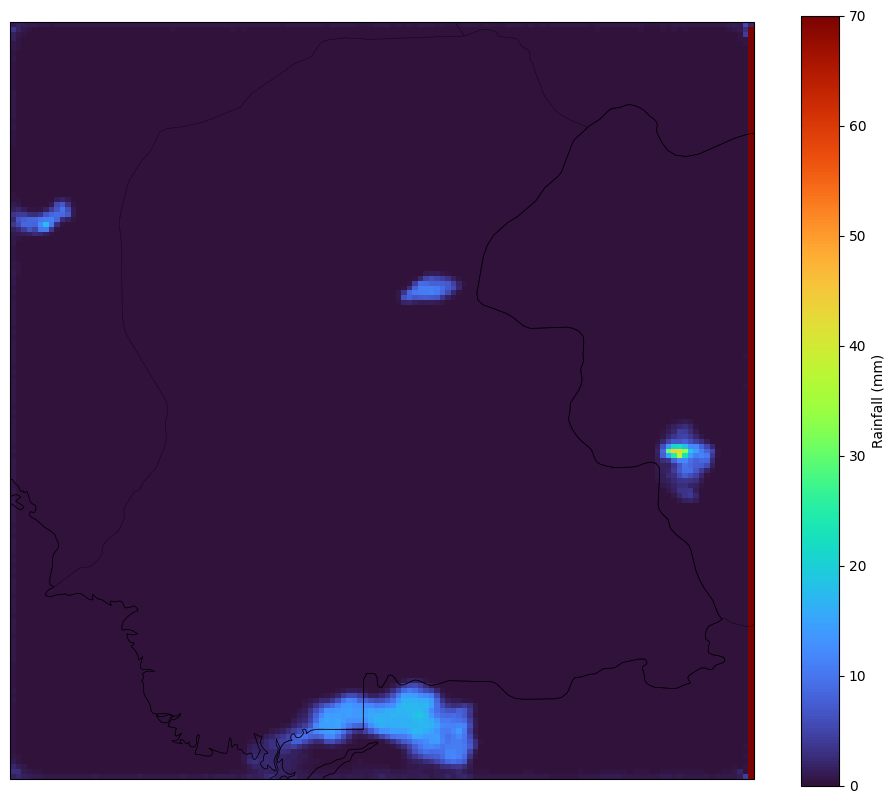

In [ ]:
precipitation_sequence = final_prediction[8]
print(precipitation_sequence[0].max())

# Define coloring scheme for plot
turbo_cmap = plt.get_cmap('turbo')
colors = [turbo_cmap(i) for i in range(0, turbo_cmap.N)]  # Adding white for 0 intensity
custom_cmap_B = LinearSegmentedColormap.from_list("white_to_turbo", colors, N=256)

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_facecolor("white")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.3)  # For finer boundaries

# Initialize the plot with the first frame
rain_plot = ax.pcolormesh(lon_subset, lat_subset, precipitation_sequence[0].cpu(), shading='auto', cmap=custom_cmap_B,
                          transform=ccrs.PlateCarree(), vmin=0, vmax=70)
cbar = plt.colorbar(rain_plot, ax=ax, orientation='vertical', label='Rainfall (mm)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Animation update function
def update(frame):
    rain_plot.set_array(precipitation_sequence[frame].cpu().detach().numpy().ravel())  # Update the data
    return rain_plot,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(precipitation_sequence), interval=500, blit=True)

# To save as a GIF
ani.save('prediction.gif', writer='imagemagick', fps=1)